# Networks of persons in relation to organisations


* Pajek book chapter ...
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/networkx_slicing_with_cores.ipynb) avec simple examples



In [111]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd


import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [112]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [113]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [114]:
print(reload(naf))  

<module 'network_analysis_functions' from 'c:\\Users\\laila\\OneDrive\\Documents\\Uni\\2e année\\Semestre 4\\Application de méthodes numériques pour les sciences humaines et historiques\\French_CEOs\\notebooks_jupyter\\network_analysis_functions.py'>


## Get the data from the triplestore

...  [compléter]


In [115]:
## define SPARQL enpoint
endpoint = "https://ag15yee0az6rmk64.allegrograph.cloud/repositories/ceos"

In [116]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/Laillaa/French_CEOs/blob/main/graphs/Wikidata-imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                 wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [117]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


3839
[['http://www.wikidata.org/entity/Q105693319',
  'Laurent Prud’homme',
  '1974',
  'membership',
  'http://www.wikidata.org/entity/Q131137989',
  'emlyon alumni',
  '2',
  'alumni association | organization'],
 ['http://www.wikidata.org/entity/Q105693319',
  'Laurent Prud’homme',
  '1974',
  'education',
  'http://www.wikidata.org/entity/Q1795504',
  'Emlyon Business School',
  '1',
  'grande école'],
 ['http://www.wikidata.org/entity/Q105693319',
  'Laurent Prud’homme',
  '1974',
  'education',
  'http://www.wikidata.org/entity/Q662976',
  'Panthéon-Assas University Paris',
  '1',
  'university in France']]


## Inspect the data


In [118]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesO']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  3839


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO
10,http://www.wikidata.org/entity/Q100997694,Jean-Luc Chetrit,1965,education,http://www.wikidata.org/entity/Q1795504,Emlyon Business School,1,grande école
11,http://www.wikidata.org/entity/Q101112672,Markus Krah,1968,education,http://www.wikidata.org/entity/Q1688743,Jewish Theological Seminary of America,2,Jewish seminary | private not-for-profit educa...
12,http://www.wikidata.org/entity/Q101112672,Markus Krah,1968,education,http://www.wikidata.org/entity/Q168000,American University,3,private not-for-profit educational institution...


### Distribution of relationships in relation to birthYears

In [119]:
l_50 = list(range(1751, 2051, 50))
print(l_50)

[1751, 1801, 1851, 1901, 1951, 2001]


In [120]:
### We adapt the periods manually
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [121]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [122]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods
0,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,education,http://www.wikidata.org/entity/Q34433,University of Oxford,6,educational organization | public university |...,1961-1980
1,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,education,http://www.wikidata.org/entity/Q5316528,Durham Johnston Comprehensive School,2,secondary school | community school,1961-1980
2,http://www.wikidata.org/entity/Q100276124,Parag Agrawal,1984,education,http://www.wikidata.org/entity/Q41506,Stanford University,4,research university | private university | pri...,1981-2000


#### Save dataframe to CSV

In [123]:
file_add = '../persons_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

In [124]:
### load from CSV

file_add = '../persons_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

3839


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods
0,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,education,http://www.wikidata.org/entity/Q34433,University of Oxford,6,educational organization | public university |...,1961-1980
1,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,education,http://www.wikidata.org/entity/Q5316528,Durham Johnston Comprehensive School,2,secondary school | community school,1961-1980


In [125]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1801-1850       7
1851-1900      54
1901-1920      84
1921-1940     259
1941-1960    1230
1961-1980    1660
1981-2000     545
dtype: int64


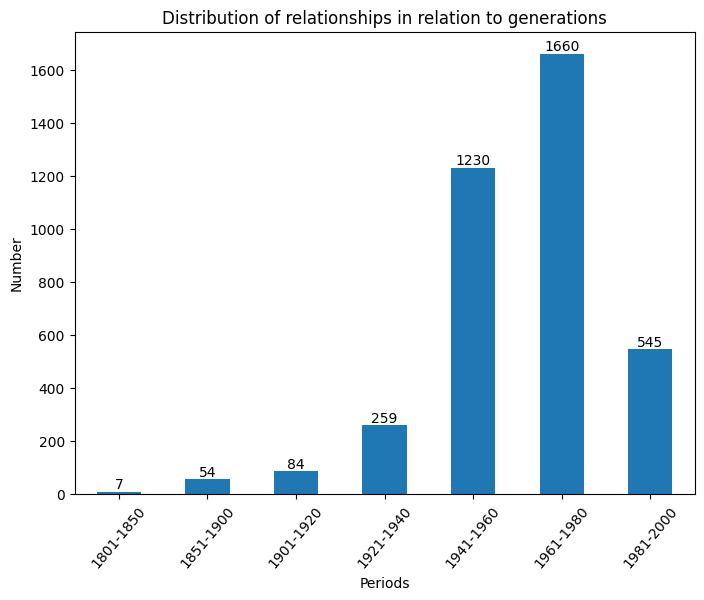

In [126]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Types of organisations

In [127]:
### convert birthYear to integer
df_p['listTypesO'] = df_p.typesO.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

# decompose in the tokens, unique
df_p['listTokensTypesO'] = df_p.listTypesO.apply(lambda x : sorted(list(set([e for e in (' '.join(x)).split(' ') if len(e) > 2]))))

pprint.pprint(df_p.head().listTypesO.to_list())
print('-----')
pprint.pprint(df_p.head().listTokensTypesO.to_list())

[['collegiate university',
  'educational organization',
  'exempt charity',
  'higher education institution',
  'organization',
  'public university'],
 ['community school', 'secondary school'],
 ['open-access publisher',
  'private not-for-profit educational institution',
  'private university',
  'research university'],
 ['school'],
 ['institute of technology']]
-----
[['charity',
  'collegiate',
  'education',
  'educational',
  'exempt',
  'higher',
  'institution',
  'organization',
  'public',
  'university'],
 ['community', 'school', 'secondary'],
 ['educational',
  'institution',
  'not-for-profit',
  'open-access',
  'private',
  'publisher',
  'research',
  'university'],
 ['school'],
 ['institute', 'technology']]


In [128]:
ll = df_p.listTypesO.to_list()
print(len(ll))
print(ll[:3])

3839
[['collegiate university', 'educational organization', 'exempt charity', 'higher education institution', 'organization', 'public university'], ['community school', 'secondary school'], ['open-access publisher', 'private not-for-profit educational institution', 'private university', 'research university']]


In [129]:
llj = [' | '.join(b) for b in ll]
print(len(llj))
print(llj[:3])

3839
['collegiate university | educational organization | exempt charity | higher education institution | organization | public university', 'community school | secondary school', 'open-access publisher | private not-for-profit educational institution | private university | research university']


In [130]:
ls = pd.Series(llj)
ltg = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ltg.reset_index(inplace=True)
ltg.columns=['orgType_group', 'effectif']
ltg.head()


,orgType_group,effectif
0,grande école,201
1,alumni association | organization,182
2,business school,175
3,high school,125
4,university,125


In [131]:
csv_file='../network_organisations_types_groups.csv'
ltg.to_csv(csv_file)
print(ltg.iloc[30:40])

                                        orgType_group  effectif
30                                         law school        20
31  academic publisher | grand établissement | gra...        19
32  educational organization | higher education in...        19
33  open-access publisher | private not-for-profit...        18
34                               educational facility        18
35  academic publisher | colonial colleges | priva...        18
36  open-access publisher | organization | public ...        18
37                            institute of technology        17
38          organization | public research university        17
39                                          gymnasium        16


#### Wikidata 'instance of'

In [132]:
ll = df_p.listTypesO.to_list()
print(len(ll))

3839


In [133]:
ltt = [a for b in df_p.listTypesO.to_list() for a in b]
print(len(ltt))

8548


In [134]:
ls = pd.Series(ltt)


In [135]:
ltg = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ltg.reset_index(inplace=True)
ltg.columns=['organisation', 'effectif']
ltg.head()


,organisation,effectif
0,university,717
1,organization,558
2,open-access publisher,527
3,private not-for-profit educational institution,473
4,public university,418


In [136]:
csv_file='../network_organisations_types.csv'
ltg.to_csv(csv_file)
print(ltg.iloc[30:40])

             organisation  effectif
30     independent school        52
31                faculty        49
32             law school        48
33    engineering college        42
34     production company        42
35    catholic university        34
36        learned society        34
37   academic institution        33
38  collegiate university        33
39        graduate school        32


#### Wikidata tokens of 'instance of'

In [137]:
ll = df_p.listTokensTypesO.to_list()
print(len(ll))

3839


In [138]:
ltt = [a for b in df_p.listTokensTypesO.to_list() for a in b]
print(len(ltt))

16770


In [139]:
ls = pd.Series(ltt)
ltg = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ltg.reset_index(inplace=True)
ltg.columns=['token', 'effectif']
ltg.head()


,token,effectif
0,university,1997
1,institution,1007
2,educational,990
3,public,935
4,school,879


In [140]:
csv_file='../network_organisations_types_tokens.csv'
ltg.to_csv(csv_file)
print(ltg.iloc[30:40])

         token  effectif
30    location        81
31  geographic        81
32   secondary        74
33  technology        73
34   nonprofit        72
35     academy        70
36     ottoman        68
37    building        64
38    boarding        63
39      france        63


### Add education period

In [141]:
### Add constructed education period
df_p['BeginY'] = df_p[df_p.relaType=='education'].birthYear.apply(lambda x : x + 18)
df_p['EndY'] = df_p[df_p.relaType=='education'].birthYear.apply(lambda x : x + 29)
df_p.iloc[5:9]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods,listTypesO,listTokensTypesO,BeginY,EndY
5,http://www.wikidata.org/entity/Q100705519,Ponce,1991,education,http://www.wikidata.org/entity/Q3578313,École polytechnique universitaire de Montpellier,2,engineering college | grande école,1981-2000,"[engineering college, grande école]","[college, engineering, grande, école]",2009.0,2020.0
6,http://www.wikidata.org/entity/Q100705519,Ponce,1991,education,http://www.wikidata.org/entity/Q2994588,Toulouse Regional Conservatory,5,former hospital | drama school | educational i...,1981-2000,"[conservatories with regional coverage, drama ...","[building, conservatories, coverage, drama, ed...",2009.0,2020.0
7,http://www.wikidata.org/entity/Q100705519,Ponce,1991,education,http://www.wikidata.org/entity/Q916444,Cours Florent,2,drama school | educational institution,1981-2000,"[drama school, educational institution]","[drama, educational, institution, school]",2009.0,2020.0
8,http://www.wikidata.org/entity/Q100989426,Thomas Schäfer,1970,education,http://www.wikidata.org/entity/Q317070,University of Mannheim,2,organization | public university,1961-1980,"[organization, public university]","[organization, public, university]",1988.0,1999.0


## Create graph for a given period


This is a graph of type 'bipartite', cf. :

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html


We do not use here the functions related to this kind of graph

In [142]:
df_p_1901 = df_p[df_p.periods=='1901-1920'].copy(deep=True)
#pprint.pprint(df_p_1901.head(2).to_dict(orient='records'))

df_p_1961 = df_p[df_p.periods=='1961-1980'].copy(deep=True)
#pprint.pprint(df_p_1961.head(2).to_dict(orient='records'))

df_in_use = df_p_1901


In [143]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer'], e['uriOrg'],
     {'relaType':e['relaType']}
     )) 
     for e in df_in_use.to_dict(orient='records')]
print(len(l))

84


In [144]:
bip_g = nx.Graph()

bip_g.add_edges_from(l)
naf.basic_graph_properties(bip_g)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 125,
 'number_of_edges': 83,
 '------': '------',
 'is connected': False,
 'components': 42,
 'density': 0.010709677419354838}


In [145]:
### Number of types of relationships
le = list(bip_g.edges.data())
# print([e[2]['relaType'] for e in le][:3]) 
srt = pd.Series([e[2]['relaType'] for e in le])
print(srt.groupby(by=srt).size())

education     63
employment     6
membership    14
dtype: int64


#### Add metadata to nodes

In [146]:
df_p1 = df_in_use[['uriPer','labelPer','birthYear']]
df_p1 = df_p1.drop_duplicates()
df_p1.columns=['uri', 'label', 'birthYear']
df_p1.head(2)

,uri,label,birthYear
105,http://www.wikidata.org/entity/Q105771371,Leonard H. Straus,1914
117,http://www.wikidata.org/entity/Q105932307,Georges Coutellier,1912


In [147]:
### Add data to nodes

## Prepare data to import
l = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear'],
      'bipartite':0}
     ) for e in df_p1.to_dict(orient='records')])
# print(str(l)[:200])

In [148]:

## Add attributes
nx.set_node_attributes(bip_g, l)
pprint.pprint(list(bip_g.nodes.data())[:3])


[('http://www.wikidata.org/entity/Q105771371',
  {'bipartite': 0, 'birthYear': 1914, 'label': 'Leonard H. Straus'}),
 ('http://www.wikidata.org/entity/Q49122', {}),
 ('http://www.wikidata.org/entity/Q499451', {})]


In [149]:
df_p2 = df_in_use[['uriOrg','labelOrg']]
df_p2 = df_p2.drop_duplicates()
df_p2.columns=['uri', 'label']
df_p2.head(2)

,uri,label
105,http://www.wikidata.org/entity/Q49122,Harvard Law School
106,http://www.wikidata.org/entity/Q499451,Rutgers University


In [150]:
### Add data to nodes

## Prepare data to import
l = dict([(e['uri'],
     {'label':e['label'],
      'bipartite':1}
     ) for e in df_p2.to_dict(orient='records')])
# print(str(l)[:200])

In [151]:
## Add attributes
nx.set_node_attributes(bip_g, l)
pprint.pprint(list(bip_g.nodes.data())[:3])

[('http://www.wikidata.org/entity/Q105771371',
  {'bipartite': 0, 'birthYear': 1914, 'label': 'Leonard H. Straus'}),
 ('http://www.wikidata.org/entity/Q49122',
  {'bipartite': 1, 'label': 'Harvard Law School'}),
 ('http://www.wikidata.org/entity/Q499451',
  {'bipartite': 1, 'label': 'Rutgers University'})]


#### Partition 

We can observe that there is one big partition, with approximately 5000 nodes, and around 42 small ones, comprizing 6 nodes or less


We first explore small partitions

In [152]:
### Create a list of graphs, one per component
S = [bip_g.subgraph(c).copy() for c in nx.connected_components(bip_g)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True)
print(len (ln))
print(ln[:5])

42
[[39, 16], [1, 6], [38, 6], [24, 5], [10, 4]]


In [153]:
### 
li = [6, 12, 30]    # [12, 15, 43]
ll = [list(S[i[0]].nodes.data()) for i in ln if i[0] in li ]
pprint.pprint(ll[0][:2])

[('http://www.wikidata.org/entity/Q120269787',
  {'bipartite': 0, 'birthYear': 1908, 'label': 'Viktor Dzhaparidze'}),
 ('http://www.wikidata.org/entity/Q1425119',
  {'bipartite': 1, 'label': 'Georgian Technical University'})]


In [154]:
li = li
pG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    pG = nx.union(pG, S[i])
print(bipartite.is_bipartite(pG))   
naf.basic_graph_properties(pG)

True
{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 6,
 'number_of_edges': 3,
 '------': '------',
 'is connected': False,
 'components': 3,
 'density': 0.2}


C:\Users\laila\AppData\Local\Temp\ipykernel_17372\2483013313.py:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=60)


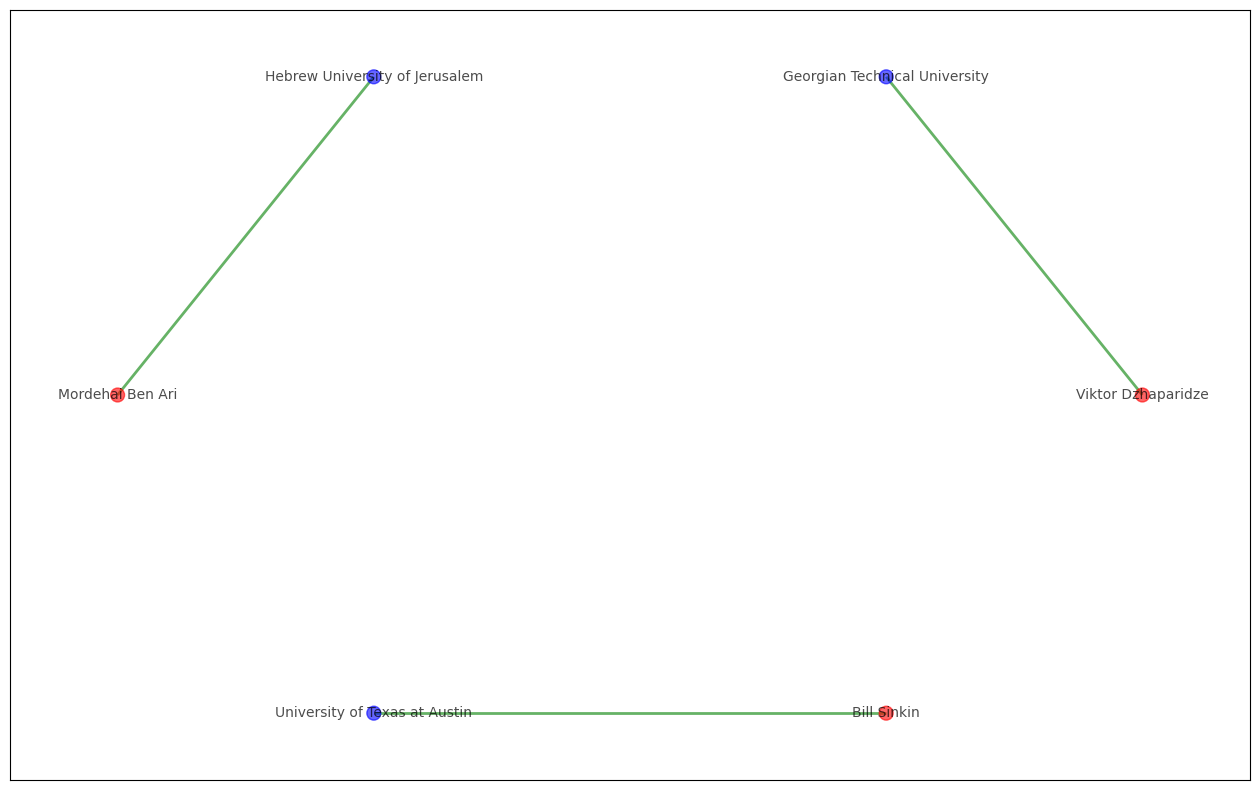

In [155]:
### Plot the graph

g = pG

graph_layout = 'kamada_kawai'
n_k = 0.8
sc = 20

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (16,10))

node_size = [d[1]*100 for d in nx.degree(g)]
node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in g.nodes.data()])
node_colors = ['red' if n[1]['bipartite'] == 0 else 'blue' for n in g.nodes.data()]
edge_colors = ['blue' if n[2]['relaType'] == 'employment' 
               else 'red' if n[2]['relaType'] == 'membership' 
               else 'green' for n in g.edges.data()]


nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.6)
nx.draw_networkx_edges(g, pos, edge_color=edge_colors, width=2, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
#plt.savefig('images/small_bipartite_component.svg')
plt.show()


#### Biggest component

In [156]:
li = [0]
big_u = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_u = nx.union(big_u, S[i])
print(bipartite.is_bipartite(big_u))   
naf.basic_graph_properties(big_u)

True
{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 3,
 'number_of_edges': 2,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.6666666666666666}


In [157]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_u)])
nx.set_node_attributes(big_u, degree)
pprint.pprint(list(big_u.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q105771371',
  {'bipartite': 0,
   'birthYear': 1914,
   'degree': 2,
   'label': 'Leonard H. Straus'}),
 ('http://www.wikidata.org/entity/Q49122',
  {'bipartite': 1, 'degree': 1, 'label': 'Harvard Law School'})]


In [158]:
### Add eivenvalue to nodes
eigenvector = nx.eigenvector_centrality(big_u, max_iter=300)
nx.set_node_attributes(big_u, eigenvector, 'eigenvector')
pprint.pprint(list(big_u.nodes.data())[1:3])

[('http://www.wikidata.org/entity/Q49122',
  {'bipartite': 1,
   'degree': 1,
   'eigenvector': 0.5000000644180599,
   'label': 'Harvard Law School'}),
 ('http://www.wikidata.org/entity/Q499451',
  {'bipartite': 1,
   'degree': 1,
   'eigenvector': 0.5000000644180599,
   'label': 'Rutgers University'})]


In [159]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number

core_numbers = nx.core_number(big_u)
print(str(core_numbers)[:150])

{'http://www.wikidata.org/entity/Q105771371': 1, 'http://www.wikidata.org/entity/Q49122': 1, 'http://www.wikidata.org/entity/Q499451': 1}


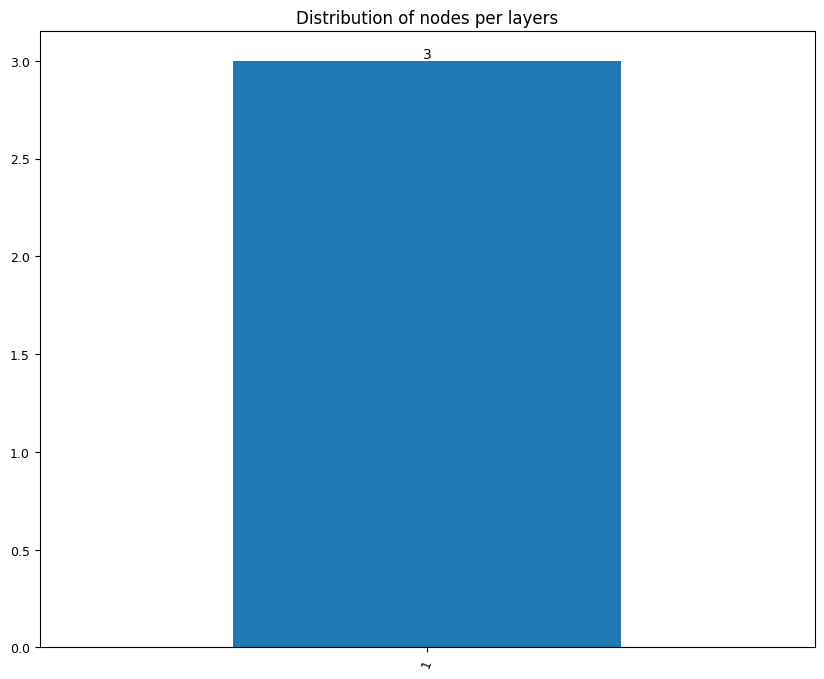

In [160]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8))
plt.title('Distribution of nodes per layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [161]:
# Identify communities based on core numbers
communities = {}
for node, core_number in core_numbers.items():
    if core_number not in communities:
        communities[core_number] = [node]
    else:
        communities[core_number].append(node)

# Print the communities
cts = []
for core_number, community in communities.items():
    print(f"Community {core_number}: {len(community)}, {community[:5]}")
    cts.append([core_number,len(community),community])



Community 1: 3, ['http://www.wikidata.org/entity/Q105771371', 'http://www.wikidata.org/entity/Q49122', 'http://www.wikidata.org/entity/Q499451']


In [162]:
cts=sorted(cts, key=lambda x: x[0])
p=[pprint.pprint([e[0],e[1],e[2][:3] ]) for e in cts]

[1,
 3,
 ['http://www.wikidata.org/entity/Q105771371',
  'http://www.wikidata.org/entity/Q49122',
  'http://www.wikidata.org/entity/Q499451']]


In [163]:
### get all nodes with 
ln = [ k  for k,v in core_numbers.items()  if v >= 6]
print(len(ln), ln[:2])

0 []


In [164]:
"""cG = big_u.subgraph(ln)
naf.basic_graph_properties(cG)
pprint.pprint(list(cG.nodes.data())[:1])"""

'cG = big_u.subgraph(ln)\nnaf.basic_graph_properties(cG)\npprint.pprint(list(cG.nodes.data())[:1])'

In [165]:
"""### Same result by using the k_core function
kc_G = nx.k_core(big_u, 6)
naf.basic_graph_properties(kc_G)
pprint.pprint(list(kc_G.nodes.data())[:1])"""

'### Same result by using the k_core function\nkc_G = nx.k_core(big_u, 6)\nnaf.basic_graph_properties(kc_G)\npprint.pprint(list(kc_G.nodes.data())[:1])'

In [166]:
### Plot degree distribution
d = [d[1] for d in nx.degree(kc_G)]
naf.describe_plot_integers_distribution(d, 12,6,'Degree distribution')

TypeError: describe_plot_integers_distribution() takes from 2 to 3 positional arguments but 4 were given

In [ ]:
### 

g = kc_G

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 50 #*25

graph_layout = 'spring_layout'
n_k = 0.5
sc = 0.02

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = ['red' if n[1]['bipartite'] == 0 else 'blue' for n in g.nodes.data()]

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_bipartite_component_test.svg')
plt.close()
#plt.plot()

#### Explore the degree centrality and eigenvector

In [ ]:
export = pd.DataFrame(kc_G.nodes.data(), columns = ['id', 'attributes'])
attributes = pd.json_normalize(export.attributes)

export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export.drop(columns=['attributes'], inplace=True)
round(attributes, 3)
export.head(2)
#pprint.pprint(list(nd[:3]))

In [ ]:
### Most frequent persons/organisations by degree or eigenvector (replace in the sort clause !)
## The degree is definitely higher for universities, but the eigenvector can also be high for persons
# and this insofar as they studied in high-degree institutions
export.sort_values(by='eigenvector', ascending=False)[['label', 'bipartite', 'degree', 'eigenvector']].iloc[:20]

In [ ]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


### Please note the filter !
#  
## Values 0 : persons, 1 : organisations  / change rows iloc filter if needed ! 
exp = export[export.bipartite==0].sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

## Please consider:
## https://how2matplotlib.com/matplotlib-scatter-label.html

plt.scatter(exp['degree'][(exp.bipartite == 0)], 
            exp['eigenvector'][(exp.bipartite == 0)],
           marker='o',
           color='Coral',
           label='pers'
           )
plt.scatter(exp['degree'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
            exp['eigenvector'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
           marker='D',
           color='DarkCyan',
           label='org')
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']))
plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


### Please note the filter !
#  
## Values 0 : persons, 1 : organisations  / change rows iloc filter if needed ! 
exp = export[export.bipartite==1].sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

## Please consider:
## https://how2matplotlib.com/matplotlib-scatter-label.html

plt.scatter(exp['degree'][(exp.bipartite == 0)], 
            exp['eigenvector'][(exp.bipartite == 0)],
           marker='o',
           color='Coral',
           label='pers'
           )
plt.scatter(exp['degree'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
            exp['eigenvector'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
           marker='D',
           color='DarkCyan',
           label='org')
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']))
plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

## Create graph of persons relationships during studies

In [167]:
print(list(df_p.columns))
df_p.head(2)

['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes', 'typesO', 'periods', 'listTypesO', 'listTokensTypesO', 'BeginY', 'EndY']


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods,listTypesO,listTokensTypesO,BeginY,EndY
0,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,education,http://www.wikidata.org/entity/Q34433,University of Oxford,6,educational organization | public university |...,1961-1980,"[collegiate university, educational organizati...","[charity, collegiate, education, educational, ...",1994.0,2005.0
1,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,education,http://www.wikidata.org/entity/Q5316528,Durham Johnston Comprehensive School,2,secondary school | community school,1961-1980,"[community school, secondary school]","[community, school, secondary]",1994.0,2005.0


### Prepare and create the graph

In [168]:
### Select the columns that will be used
df_sel = df_p[df_p.relaType=='education'][['uriPer','uriOrg', 'labelOrg', 'BeginY','EndY', 'periods']].copy(deep=True)
print(len(df_sel))

3288


In [169]:
### Join on common organisation -> produces a lot of rows !
merged = pd.merge(df_sel, df_sel, on=['uriOrg', 'labelOrg'])
print(len(merged))


64454


In [170]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriPer_x'] < (merged['uriPer_y'])]
print(len(merged))

30583


In [171]:
### Restrict time overlap (allow only 8 years overlap) — could be extended to have a larger result
merged = merged[(merged['BeginY_y']+2 < merged['EndY_x']-2) & (merged['BeginY_x']+2 < merged['EndY_y']-2)]
print(len(merged))
merged = merged[['uriPer_x', 'uriPer_y', 'uriOrg', 'labelOrg', 'periods_x', 'BeginY_x', 'EndY_x',  'BeginY_y', 'EndY_y', 'periods_y']]



8495


In [172]:
print(len(merged))
print(list(merged.columns))
merged.head()

8495
['uriPer_x', 'uriPer_y', 'uriOrg', 'labelOrg', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y']


,uriPer_x,uriPer_y,uriOrg,labelOrg,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
3,http://www.wikidata.org/entity/Q100158636,http://www.wikidata.org/entity/Q131551153,http://www.wikidata.org/entity/Q34433,University of Oxford,1961-1980,1994.0,2005.0,1991.0,2002.0,1961-1980
5,http://www.wikidata.org/entity/Q100158636,http://www.wikidata.org/entity/Q16222044,http://www.wikidata.org/entity/Q34433,University of Oxford,1961-1980,1994.0,2005.0,2000.0,2011.0,1981-2000
6,http://www.wikidata.org/entity/Q100158636,http://www.wikidata.org/entity/Q18150111,http://www.wikidata.org/entity/Q34433,University of Oxford,1961-1980,1994.0,2005.0,1997.0,2008.0,1961-1980
8,http://www.wikidata.org/entity/Q100158636,http://www.wikidata.org/entity/Q37321267,http://www.wikidata.org/entity/Q34433,University of Oxford,1961-1980,1994.0,2005.0,1997.0,2008.0,1961-1980
9,http://www.wikidata.org/entity/Q100158636,http://www.wikidata.org/entity/Q42594329,http://www.wikidata.org/entity/Q34433,University of Oxford,1961-1980,1994.0,2005.0,1994.0,2005.0,1961-1980


In [173]:
### Group by persons' pairs and count/aggregate organisations

## This is needed because the nx.add_edges_from() function applies
# a DISTINCT approach and information will be lost if two persons
# are related by more than one organisation 

gr_mer = merged.groupby(['uriPer_x', 'uriPer_y', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y'], as_index = False)\
    .agg({'labelOrg': '|'.join, 'uriOrg': '|'.join})
gr_mer['number'] = gr_mer.labelOrg.apply(lambda x : len(x.split('|')))
print(len(gr_mer))


8302


In [174]:
### change columns names
gr_mer.columns= ['uriPer_x', 'uriPer_y', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y', 'orgs', 'uriOrgs', 'numberOrgs']

In [175]:
### change columns positions
gr_mer = gr_mer[['uriPer_x', 'uriPer_y', 'orgs', 'numberOrgs', 'uriOrgs', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y']]
gr_mer.head(2)

,uriPer_x,uriPer_y,orgs,numberOrgs,uriOrgs,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
0,http://www.wikidata.org/entity/Q100158636,http://www.wikidata.org/entity/Q131551153,University of Oxford,1,http://www.wikidata.org/entity/Q34433,1961-1980,1994.0,2005.0,1991.0,2002.0,1961-1980
1,http://www.wikidata.org/entity/Q100158636,http://www.wikidata.org/entity/Q16222044,University of Oxford,1,http://www.wikidata.org/entity/Q34433,1961-1980,1994.0,2005.0,2000.0,2011.0,1981-2000


In [177]:
### Store the information from the SPARQL query in a CSV file
# in order to be able to upload it witout executing the query again
file_add = '../persons_common_education.csv'
try:
    gr_mer.to_csv(file_add)
    print('Written!')
except Exception as e:
    print(e)


Written!


In [178]:
### sort by multiple relationships
gr_mer[['uriPer_x','uriPer_y','orgs','numberOrgs']].sort_values(by='numberOrgs', ascending=False).iloc[:7]

,uriPer_x,uriPer_y,orgs,numberOrgs
3204,http://www.wikidata.org/entity/Q123396704,http://www.wikidata.org/entity/Q124589753,"IAE Lyon, University of Lyon School Management...",3
5117,http://www.wikidata.org/entity/Q14927550,http://www.wikidata.org/entity/Q16728313,Harvard University|Harvard College|Harvard Bus...,3
7513,http://www.wikidata.org/entity/Q3443484,http://www.wikidata.org/entity/Q348874,Massachusetts Institute of Technology|Sloan Fe...,3
2277,http://www.wikidata.org/entity/Q114561393,http://www.wikidata.org/entity/Q33197585,Emlyon Business School|Institut National des S...,2
3240,http://www.wikidata.org/entity/Q123396704,http://www.wikidata.org/entity/Q62572964,"IAE Lyon, University of Lyon School Management...",2
973,http://www.wikidata.org/entity/Q107749830,http://www.wikidata.org/entity/Q96593178,Tel Aviv University|Harvard University,2
3981,http://www.wikidata.org/entity/Q125627036,http://www.wikidata.org/entity/Q125737767,Emlyon Business School|Jean Moulin University ...,2


In [179]:
### store multiple relationships in order to explore them in the CSV
file_add = '../persons_education_rel_multiple.csv'
gr_mer[gr_mer.numberOrgs > 1].sort_values(by='numberOrgs', ascending=False).to_csv(file_add)

#### Example of connected persons

Displayed with **Allegrograph Gruff**

<img src="images/alg_gruff_example_chinese_connected_education.png" alt="drawing" width="700"/>

In [181]:
### Find persons in different periods

## We observe that there is significant overlap: more than 30000
# Periods are as a matter of fact an artificial construct !

print(len(gr_mer[gr_mer.periods_x != gr_mer.periods_y]))
gr_mer[gr_mer.periods_x != gr_mer.periods_y].sort_values(by='numberOrgs', ascending=False).iloc[:5]

1311


,uriPer_x,uriPer_y,orgs,numberOrgs,uriOrgs,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
5113,http://www.wikidata.org/entity/Q14927550,http://www.wikidata.org/entity/Q14948741,Harvard University|Harvard Business School,2,http://www.wikidata.org/entity/Q13371|http://w...,1941-1960,1978.0,1989.0,1980.0,1991.0,1961-1980
3671,http://www.wikidata.org/entity/Q12405769,http://www.wikidata.org/entity/Q6853902,Reichman University|Tel Aviv University,2,http://www.wikidata.org/entity/Q2908845|http:/...,1941-1960,1977.0,1988.0,1981.0,1992.0,1961-1980
4624,http://www.wikidata.org/entity/Q131540062,http://www.wikidata.org/entity/Q33101796,Emlyon Business School|HEC Paris,2,http://www.wikidata.org/entity/Q1795504|http:/...,1961-1980,1979.0,1990.0,1976.0,1987.0,1941-1960
3866,http://www.wikidata.org/entity/Q124589753,http://www.wikidata.org/entity/Q125627036,Emlyon Business School|Jean Moulin University ...,2,http://www.wikidata.org/entity/Q1795504|http:/...,1961-1980,1996.0,2007.0,2001.0,2012.0,1981-2000
3867,http://www.wikidata.org/entity/Q124589753,http://www.wikidata.org/entity/Q125737767,Emlyon Business School|Jean Moulin University ...,2,http://www.wikidata.org/entity/Q1795504|http:/...,1961-1980,1996.0,2007.0,1999.0,2010.0,1981-2000


### Create the graph

In [182]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer.to_dict(orient='records')]
print(len(l))

8302


In [183]:
print(len(gr_mer))

8302


In [184]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 1050,
 'number_of_edges': 8302,
 '------': '------',
 'is connected': False,
 'components': 71,
 'density': 0.015074674292977439}


#### Add metadata to nodes

In [185]:
df_pm = df_p[['uriPer','labelPer','birthYear']]
df_pm = df_pm.drop_duplicates()
df_pm.columns=['uri', 'label', 'birthYear']
df_pm.head()


,uri,label,birthYear
0,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976
2,http://www.wikidata.org/entity/Q100276124,Parag Agrawal,1984
5,http://www.wikidata.org/entity/Q100705519,Ponce,1991
8,http://www.wikidata.org/entity/Q100989426,Thomas Schäfer,1970
9,http://www.wikidata.org/entity/Q100997694,Jean-Luc Chetrit,1965


In [187]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [188]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q100158636',
  {'birthYear': 1976, 'label': 'Amanda Pritchard'}),
 ('http://www.wikidata.org/entity/Q131551153',
  {'birthYear': 1973, 'label': 'Roland Palmer'})]


## Explore the education relationships graph

In [189]:
naf.basic_graph_properties(ppG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 1050,
 'number_of_edges': 8302,
 '------': '------',
 'is connected': False,
 'components': 71,
 'density': 0.015074674292977439}


#### Components

In [190]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])

### Again we observe that there is a big connected graphe 
# and a multitude of small graphs

[[0, 859], [22, 12], [12, 8], [2, 6], [7, 5]]


### Explore small graph

In [191]:
### 
li = [117]    # [12, 15, 43]
ll = [list(perS[i[0]].nodes.data()) for i in ln if i[0] in li ]
#pprint.pprint(str(ll)[:300])

In [ ]:

# Display variable

u_117 = nx.Graph()

for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    u_117 = nx.union(u_117, perS[i])
naf.basic_graph_properties(u_117)


[]


NetworkXPointlessConcept: Connectivity is undefined for the null graph.

In [193]:
### 

g = u_117

# print(list(g.nodes.data())[:3])
# print(list(g.edges.data())[:3])

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 30 #*25

graph_layout = 'kamada_kawai'
n_k = 0.4
sc = 0.02

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)


# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [d[1]*100 for d in nx.degree(g)]
node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in g.nodes.data()])
print(node_labels)
edge_labels = {e: g.get_edge_data(e[0], e[1])["orgsLabels"] for e in g.edges()}
print(edge_labels)


### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_size=node_size, alpha=0.4)
nx.draw_networkx_edges(g, pos, label=edge_labels, width=4, alpha=0.2) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=20)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_labels, alpha=0.6)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
#plt.savefig('images/small_bipartite_component.svg')
plt.show()


C:\Users\laila\AppData\Local\Temp\ipykernel_17372\3921559036.py:8: RuntimeWarning: divide by zero encountered in log
  n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 30 #*25


ValueError: figure size must be positive finite not (np.float64(-inf), np.float64(-inf))

In [ ]:
df_p[(df_p.labelOrg.str.contains('Kyiv Poly'))& df_p.relaType.str.contains('educa')].head()

#### Composante principale

In [ ]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



In [ ]:
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)
pprint.pprint(list(big_ppG.nodes.data())[:2])


### Degree distribution and slicing

In [ ]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

In [ ]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
# Plot the distribution of eigenvector density

plt.figure(figsize=(20, 6))
p = sns.violinplot(data=eigenvector_s[eigenvector_s> 0.00013610493515402787], orient='h')
plt.title('Eigenvector Distribution Density')
plt.show()

In [ ]:
print(len(eigenvector_s[eigenvector_s> 0.01]))

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:300]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
gr_mer.head(2)

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
file_add='data/connecting_orgs.csv'
connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

### Slicing with cores

In [ ]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

In [ ]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [ ]:
# Identify communities based on core numbers
communities = {}
for node, core_number in core_numbers.items():
    if core_number not in communities:
        communities[core_number] = [node]
    else:
        communities[core_number].append(node)

# Print the communities
cts = []
for core_number, community in communities.items():
    # print(f"Community {core_number}: {len(community)}, {community[:5]}")
    cts.append([core_number,len(community),community])



In [ ]:
cts=sorted(cts, key=lambda x: x[0])
pprint.pprint([[e[0], e[1] ] for e in cts])

In [ ]:
### 
ln = [ k  for k,v in core_numbers.items()  if v >= 65]
print(len(ln), ln[:3])

In [ ]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


In [ ]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(SG)
nx.set_node_attributes(SG, betweenness, 'betweenness')
pprint.pprint(list(SG.nodes.data())[:2])

In [ ]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.4
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*1000000+10 for n in g.nodes.data()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_education_relationships_component_test.svg')
plt.close()
#plt.plot()

## New graphs by period 

In [ ]:
gr_mer.head(2)

### Period 1851-1900

In [ ]:
gr_mer_1851_1900 = gr_mer[(gr_mer.periods_x=='1851-1900')|(gr_mer.periods_y=='1851-1900')].copy(deep=True)
len(gr_mer_1851_1900)

In [ ]:
### Distribution of relationships number
print(gr_mer_1851_1900.groupby(by='numberOrgs').size())

In [ ]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer_1851_1900.to_dict(orient='records')]
print(len(l))

In [ ]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


In [ ]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [ ]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


In [ ]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])



In [ ]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



In [ ]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)


In [ ]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

In [ ]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

In [ ]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(big_ppG)
nx.set_node_attributes(big_ppG, betweenness, 'betweenness')


In [ ]:
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

In [ ]:
nodes_df.sort_values(by=['eigenvector', 'betweenness'], ascending=False).iloc[:30]

In [ ]:
### 



exp_eig = nodes_df.sort_values(by=['eigenvector', 'betweenness'], ascending=False).iloc[:30]
exp_betw = nodes_df.sort_values(by=['betweenness', 'eigenvector'], ascending=False).iloc[:30]

fig, ax = plt.subplots(1,2,figsize=(20,20) ) #  sharey=True, 

ax[0].scatter(exp_eig['eigenvector'],
            exp_eig['betweenness'],
           marker='o',
           color='DarkCyan'
           )
ax[0].set_xlabel('eigenvector')
ax[0].set_ylabel('betweenness')

for i,row in list(exp_eig[['label', 'eigenvector','betweenness']].iterrows()):
    ax[0].annotate(row['label'],(row['eigenvector'], row['betweenness']),
                 fontsize=10)
    

ax[1].scatter(exp_betw['betweenness'],
            exp_betw['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
ax[1].set_xlabel('betweenness')
ax[1].set_ylabel('eigenvector')

for i,row in list(exp_betw[['label', 'betweenness','eigenvector']].iterrows()):
    ax[1].annotate(row['label'],(row['betweenness'], row['eigenvector']),
                 fontsize=10)



#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:

# Visualize the graph with eigenvector centrality

# Position the nodes
pos = nx.spring_layout(big_ppG, k=0.2)

#node_size = [e[1]*500+10 for e in le]
degrees = [d[1] for d in big_ppG.degree()]
max_degree = max(degrees)
print(max_degree)


cmap = plt.get_cmap('Dark2')


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8,8))

# Draw the nodes and edges
#nx.draw_networkx_nodes(big_ppG, pos, ax=ax)
nx.draw_networkx_edges(big_ppG, pos, ax=ax)

# Create the ellipses
for node in big_ppG.nodes():
    width = big_ppG.nodes[node]['eigenvector']*0.7
    height = big_ppG.nodes[node]['betweenness']*0.7
    x, y = pos[node]
    degree = big_ppG.degree(node)
    color = cmap(degree / max_degree)
    ellipse = patches.Ellipse((x, y), width, height, alpha=0.5, facecolor=color)
    ax.add_patch(ellipse)
nx.draw_networkx_labels(big_ppG, pos) # ,  horizontalalignment='left'
# Set the limits and labels
#ax.set_xlim(min(pos.values(), key=lambda x: x[0])[0] - 10, max(pos.values(), key=lambda x: x[0])[0] + 10)
#ax.set_ylim(min(pos.values(), key=lambda x: x[1])[1] - 10, max(pos.values(), key=lambda x: x[1])[1] + 10)
ax.set_title('Ellipse Plot of NetworkX Graph')


plt.show()

In [ ]:
### betweenness distribution 
betweenness_s = pd.Series(list(betweenness.values()))

stats = betweenness_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
### 

g = big_ppG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.4
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*1000000+10 for n in g.nodes.data()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

In [ ]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

In [ ]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [ ]:
### 
ln = [ k  for k,v in core_numbers.items()  if v > 10]
print(len(ln), ln[:3])

In [ ]:
naf.basic_graph_properties(big_ppG)

In [ ]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


In [ ]:
b = betweenness_s.sort_values(ascending=False).iloc[40]
print(b)

In [ ]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*500000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['betweenness'] > b 
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_sliced_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

#### Egograph based on eigenvector

In [ ]:
ei = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[10]
print(ei)

In [ ]:
ln = [n[0] for n in big_ppG.nodes.data() if n[1]['eigenvector'] >= ei ]
print(len(ln), ln[1])

In [ ]:
ego_graph = nx.ego_graph(big_ppG, ln[1], radius=2)
egn = list(ego_graph.nodes())
print(egn[:2])

In [ ]:

# Display variable

egos_graph = nx.Graph()

l_nodes=[]
i = 0
while i < len(ln):
    ego_graph = nx.ego_graph(big_ppG, ln[1], radius=3)
    egn = list(ego_graph.nodes())
    l_nodes += egn
    i += 1

egos_graph = nx.subgraph(big_ppG, l_nodes)

naf.basic_graph_properties(egos_graph)


In [ ]:
pprint.pprint(list(egos_graph.nodes.data())[:2])

In [ ]:
ei2 = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[50]
print(ei2)

In [ ]:
### 

g = egos_graph

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['eigenvector']*50000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['eigenvector'] >= ei2
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_egos_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: egos_graph.nodes[node] for node in egos_graph.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='betweenness', ascending=False).iloc[:50]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['eigenvector'],
           exp['betweenness'],
            marker='o',
           color='DarkCyan'
           )
plt.xlabel('eigenvector')
plt.ylabel('betweenness')

for i,row in list(exp[['label','eigenvector', 'betweenness']].iterrows()):
    plt.annotate(row['label'],( row['eigenvector'],row['betweenness']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> ei2].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

# Conclusion

Reste à faire:

* ajouter les poids sur les relations pour calcules les paramètres de centralité
* vérifier s'il y a une correlation entre prix obtenus et centralité dans le réseau des études
* vérifier s'il y a correlation entre étudier ensemble et publier ensemble 

### Period 1901-1920

In [ ]:
gr_mer_1901_1920 = gr_mer[(gr_mer.periods_x=='1901-1920')|(gr_mer.periods_y=='1901-1920')].copy(deep=True)
print(len(gr_mer_1901_1920))

In [ ]:
### Distribution of relationships number
print(gr_mer_1901_1920.groupby(by='numberOrgs').size())

In [ ]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer_1901_1920.to_dict(orient='records')]
print(len(l))

In [ ]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


In [ ]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [ ]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


In [ ]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])



In [ ]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



In [ ]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)


In [ ]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

In [ ]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:300]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

In [ ]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(big_ppG)
nx.set_node_attributes(big_ppG, betweenness, 'betweenness')
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
print([e[1] for e in list(betweenness.items())][:3])

In [ ]:
### betweenness distribution 
betweenness_s = pd.Series(list(betweenness.values()))

stats = betweenness_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

In [ ]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [ ]:
### 
ln = [ k  for k,v in core_numbers.items()  if v > 10]
print(len(ln), ln[:3])

In [ ]:
naf.basic_graph_properties(big_ppG)

In [ ]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


In [ ]:
b = betweenness_s.sort_values(ascending=False).iloc[40]
print(b)

In [ ]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*500000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['betweenness'] > b 
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_sliced_education_relationships_component_1901_1920.svg')
plt.close()
#plt.plot()

#### Egograph based on eigenvector

In [ ]:
ei = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[10]
print(ei)

In [ ]:
ln = [n[0] for n in big_ppG.nodes.data() if n[1]['eigenvector'] >= ei ]
print(len(ln), ln[1])

In [ ]:
ego_graph = nx.ego_graph(big_ppG, ln[1], radius=2)
egn = list(ego_graph.nodes())
print(egn[:2])

In [ ]:

# Display variable

egos_graph = nx.Graph()

l_nodes=[]
i = 0
while i < len(ln):
    ego_graph = nx.ego_graph(big_ppG, ln[1], radius=3)
    egn = list(ego_graph.nodes())
    l_nodes += egn
    i += 1

egos_graph = nx.subgraph(big_ppG, l_nodes)

naf.basic_graph_properties(egos_graph)


In [ ]:
pprint.pprint(list(egos_graph.nodes.data())[:2])

In [ ]:
ei2 = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[50]
print(ei2)

In [ ]:
### 

g = egos_graph

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['eigenvector']*50000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['eigenvector'] >= ei2
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_egos_education_relationships_component_1901_1920.svg')
plt.close()
#plt.plot()

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: egos_graph.nodes[node] for node in egos_graph.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='betweenness', ascending=False).iloc[:100]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['eigenvector'],
           exp['betweenness'],
            marker='o',
           color='DarkCyan'
           )
plt.xlabel('eigenvector')
plt.ylabel('betweenness')

for i,row in list(exp[['label','eigenvector', 'betweenness']].iterrows()):
    plt.annotate(row['label'],( row['eigenvector'],row['betweenness']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> ei2].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])